In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gender-recognizer/dataset/MEN/20240705_112131.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_133142.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_160304.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240609_200332.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_160729.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_114708.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_112707.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_101942.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_154853.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240609_183952.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_111531.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_160616.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240609_202926.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_115955.jpg
/kaggle/input/gender-recognizer/dataset/MEN/20240705_122708.jpg
/kaggle/input/gender-recognizer/dataset/

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torchvision
import torchmetrics
import torch.nn as nn

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

from torchvision import transforms 
from sklearn.model_selection import train_test_split

import torchinfo
from torch.optim.lr_scheduler import StepLR

In [3]:
dataset_loc = "/kaggle/input/gender-recognizer/dataset"

In [4]:
os.listdir(dataset_loc)

['MEN', 'WOMAN']

In [5]:
men_data = os.path.join(dataset_loc, "MEN")
women_data = os.path.join(dataset_loc, "WOMAN")

In [6]:
print(men_data)
print(women_data)

/kaggle/input/gender-recognizer/dataset/MEN
/kaggle/input/gender-recognizer/dataset/WOMAN


In [7]:
data_df = pd.DataFrame(columns=["filename", "label"])
for d in tqdm(os.listdir(men_data)):
    df = pd.DataFrame({"filename":os.path.join(men_data, d), "label":"MEN"}, index=[0])
    data_df = pd.concat([data_df, df], ignore_index=True)

100%|██████████| 646/646 [00:00<00:00, 2240.63it/s]


In [8]:
for d in tqdm(os.listdir(women_data)):
    df = pd.DataFrame({"filename":os.path.join(women_data, d), "label":"WOMAN"}, index=[0])
    data_df = pd.concat([data_df, df], ignore_index=True)

100%|██████████| 647/647 [00:00<00:00, 2044.14it/s]


In [9]:
data_df.head()

,filename,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
3,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
4,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN


In [10]:
data_df.tail()

,filename,label
1288,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1289,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1290,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1291,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1292,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN


In [11]:
data_df=data_df.sample(frac=1.0).reset_index(drop=True)

In [12]:
data_df.head()

,filename,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
3,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
4,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN


In [13]:
data_df.tail()

,filename,label
1288,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1289,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1290,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1291,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1292,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN


In [14]:
for i in data_df["filename"]:
    if  (not i.endswith(".jpg")) and (not i.endswith(".png")):
        print(i)

/kaggle/input/gender-recognizer/dataset/WOMAN/6c6dcc79cb44204e1eca93838d2ab4eb6c2f027a_high.webp
/kaggle/input/gender-recognizer/dataset/WOMAN/MEN


In [15]:
data_df = data_df[data_df["filename"].str.endswith((".jpg", ".png"))]

In [16]:
data_df

,filename,label
0,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
2,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
3,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
4,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
...,...,...
1288,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN
1289,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1290,/kaggle/input/gender-recognizer/dataset/MEN/20...,MEN
1291,/kaggle/input/gender-recognizer/dataset/WOMAN/...,WOMAN


In [17]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAutocontrast(),
    transforms.RandomAdjustSharpness(2),
])

# Only reshape test data
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
])

In [18]:
class GenderRecognitionDataset(Dataset):
    def __init__(self, dataset_df, transform):
        self.dataset_df = dataset_df
        self.filenames = self.dataset_df["filename"].to_list()
        self.labels = self.dataset_df["label"].to_list()
        self.classes = sorted(list(dataset_df['label'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset_df)
    
    def __getitem__(self, idx):
        self.filename = self.filenames[idx]
        image = read_image(self.filename)
        image = image/255.0
        image = self.transform(image)
        label = self.labels[idx]
        label = torch.tensor(self.class_to_idx[label])
        return image, label

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


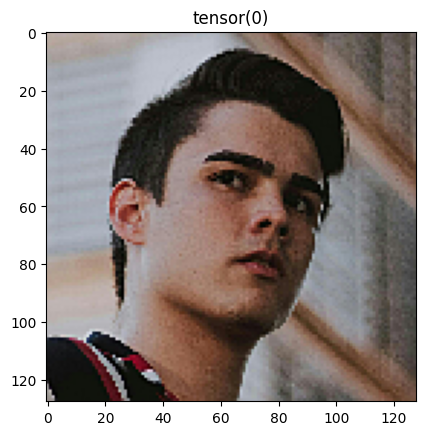

In [19]:
gdr = GenderRecognitionDataset(data_df, transform=train_transforms)
img, lab = next(iter(gdr))
plt.imshow(img.permute(1,2,0))
plt.title(lab)
plt.show()

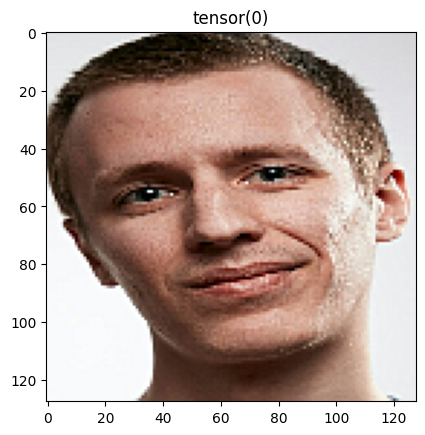

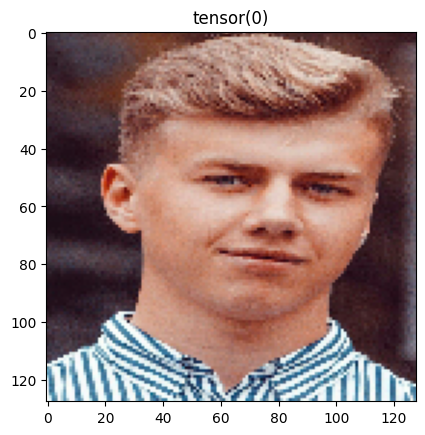

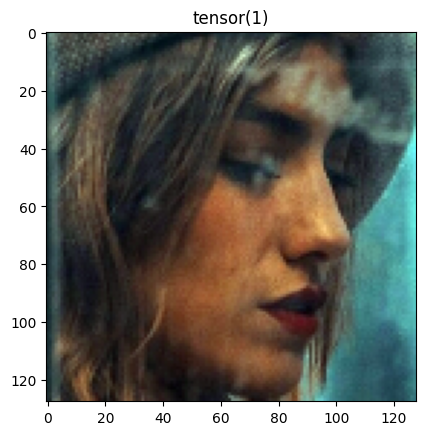

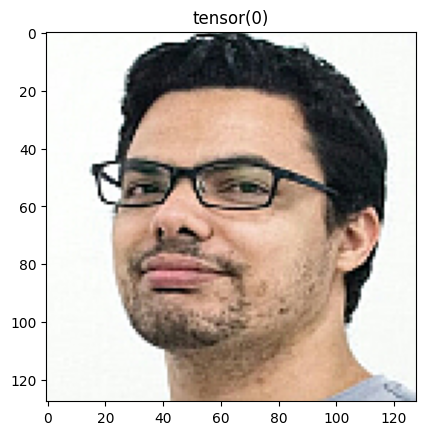

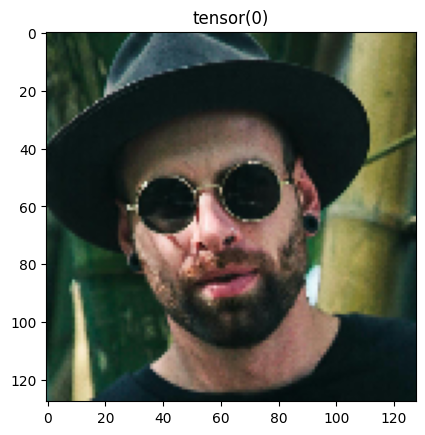

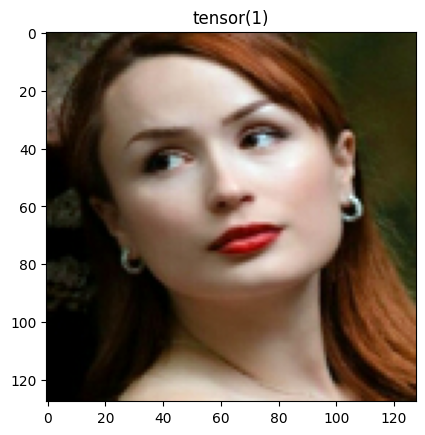

In [20]:
train_loader = DataLoader(gdr, batch_size=6, shuffle=True)
sample_images, sample_labels = next(iter(train_loader))
for img, label in zip(sample_images, sample_labels):
    plt.imshow(img.permute(1,2,0))
    plt.title(label)
    plt.show()

In [21]:
train_df, test_df = train_test_split(data_df, test_size=0.20, random_state=42)

In [22]:
train_data = GenderRecognitionDataset(train_df, train_transforms)
test_data = GenderRecognitionDataset(test_df, test_transforms)

train_dataLoader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataLoader = DataLoader(test_data, batch_size=1, shuffle=True)

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
class GenderNet(nn.Module):
    def __init__(self):
        super().__init__()      
        self.fetaure_extraction = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*32*32, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
            nn.Softmax()
        )
    
    def forward(self, x):
        x = self.fetaure_extraction(x)
        x = self.classifier(x)
        return x
    
        

In [25]:
print(device)

cuda:0


In [26]:
model = GenderNet().to(device)

In [27]:
torchinfo.summary(model, input_size=(1,3,128,128))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Layer (type:depth-idx)                   Output Shape              Param #
GenderNet                                [1, 2]                    --
├─Sequential: 1-1                        [1, 32768]                --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         448
│    └─ReLU: 2-2                         [1, 16, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 16, 128, 128]         2,320
│    └─ReLU: 2-4                         [1, 16, 128, 128]         --
│    └─Conv2d: 2-5                       [1, 16, 128, 128]         2,320
│    └─ReLU: 2-6                         [1, 16, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 16, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 32, 64, 64]           4,640
│    └─ReLU: 2-9                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-10                      [1, 32, 64, 64]           9,248
│    └─ReLU: 2-11                        [1, 32, 64, 64]           --
│ 

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.99)
scheduler = StepLR(optimizer, step_size=5, gamma=0.01)

In [35]:
training_loss = 0.0
validation_loss = 0.0 

metric = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)


In [36]:
for epoch in range(100):
    for images, labels in tqdm(train_dataLoader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        losses = criterion(predictions, labels)
        acc = metric(labels, predictions.argmax(dim=-1)) 
        training_loss += losses.item()
        losses.backward()
        optimizer.step()
        scheduler.step()
    acc = metric.compute()
    train_loss = training_loss / len(train_dataLoader)
    metric.reset()
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataLoader):
            images =  images.to(device)
            labels = labels.to(device)
            val_pred = model(images)
            losses = criterion(val_pred, labels)
            validation_loss += losses.item()
            val_acc = metric(labels, val_pred.argmax(dim=-1))
        val_acc = metric.compute()
        val_loss = validation_loss / len(test_dataLoader)
        print(f"Epoch : {epoch} |  Accuracy : {acc : 2f} | Training Loss : {train_loss : 2f} | Validation Accuracy : {val_acc : 2f} | Validation Loss : {val_loss : 2f}")
        metric.reset()
        model.train()
    
        

100%|██████████| 259/259 [00:04<00:00, 63.81it/s]


Epoch : 0 |  Accuracy :  0.493217 | Training Loss :  0.693983 | Validation Accuracy :  0.528958 | Validation Loss :  0.691894


100%|██████████| 259/259 [00:03<00:00, 69.79it/s]


Epoch : 1 |  Accuracy :  0.493217 | Training Loss :  1.387939 | Validation Accuracy :  0.528958 | Validation Loss :  1.383787


100%|██████████| 259/259 [00:03<00:00, 69.45it/s]


Epoch : 2 |  Accuracy :  0.493217 | Training Loss :  2.081894 | Validation Accuracy :  0.528958 | Validation Loss :  2.075681


100%|██████████| 259/259 [00:03<00:00, 68.78it/s]


Epoch : 3 |  Accuracy :  0.493217 | Training Loss :  2.775848 | Validation Accuracy :  0.528958 | Validation Loss :  2.767575


100%|██████████| 259/259 [00:03<00:00, 67.25it/s]


Epoch : 4 |  Accuracy :  0.493217 | Training Loss :  3.469804 | Validation Accuracy :  0.528958 | Validation Loss :  3.459469


100%|██████████| 259/259 [00:03<00:00, 68.56it/s]


Epoch : 5 |  Accuracy :  0.493217 | Training Loss :  4.163759 | Validation Accuracy :  0.528958 | Validation Loss :  4.151362


100%|██████████| 259/259 [00:03<00:00, 68.05it/s]


Epoch : 6 |  Accuracy :  0.493217 | Training Loss :  4.857714 | Validation Accuracy :  0.528958 | Validation Loss :  4.843256


100%|██████████| 259/259 [00:03<00:00, 66.68it/s]


Epoch : 7 |  Accuracy :  0.493217 | Training Loss :  5.551669 | Validation Accuracy :  0.528958 | Validation Loss :  5.535150


100%|██████████| 259/259 [00:03<00:00, 69.45it/s]


Epoch : 8 |  Accuracy :  0.493217 | Training Loss :  6.245623 | Validation Accuracy :  0.528958 | Validation Loss :  6.227044


100%|██████████| 259/259 [00:03<00:00, 69.78it/s]


Epoch : 9 |  Accuracy :  0.493217 | Training Loss :  6.939578 | Validation Accuracy :  0.528958 | Validation Loss :  6.918937


100%|██████████| 259/259 [00:03<00:00, 69.75it/s]


Epoch : 10 |  Accuracy :  0.493217 | Training Loss :  7.633533 | Validation Accuracy :  0.528958 | Validation Loss :  7.610831


100%|██████████| 259/259 [00:03<00:00, 67.93it/s]


Epoch : 11 |  Accuracy :  0.493217 | Training Loss :  8.327488 | Validation Accuracy :  0.528958 | Validation Loss :  8.302725


100%|██████████| 259/259 [00:03<00:00, 70.47it/s] 


Epoch : 12 |  Accuracy :  0.493217 | Training Loss :  9.021443 | Validation Accuracy :  0.528958 | Validation Loss :  8.994619


100%|██████████| 259/259 [00:03<00:00, 67.37it/s]


Epoch : 13 |  Accuracy :  0.493217 | Training Loss :  9.715398 | Validation Accuracy :  0.528958 | Validation Loss :  9.686512


100%|██████████| 259/259 [00:03<00:00, 68.49it/s]


Epoch : 14 |  Accuracy :  0.493217 | Training Loss :  10.409353 | Validation Accuracy :  0.528958 | Validation Loss :  10.378406


100%|██████████| 259/259 [00:03<00:00, 69.17it/s]


Epoch : 15 |  Accuracy :  0.493217 | Training Loss :  11.103308 | Validation Accuracy :  0.528958 | Validation Loss :  11.070300


100%|██████████| 259/259 [00:03<00:00, 68.31it/s]


Epoch : 16 |  Accuracy :  0.493217 | Training Loss :  11.797263 | Validation Accuracy :  0.528958 | Validation Loss :  11.762194


100%|██████████| 259/259 [00:03<00:00, 66.96it/s]


Epoch : 17 |  Accuracy :  0.493217 | Training Loss :  12.491218 | Validation Accuracy :  0.528958 | Validation Loss :  12.454087


100%|██████████| 259/259 [00:03<00:00, 68.28it/s]


Epoch : 18 |  Accuracy :  0.493217 | Training Loss :  13.185173 | Validation Accuracy :  0.528958 | Validation Loss :  13.145981


100%|██████████| 259/259 [00:03<00:00, 68.41it/s]


Epoch : 19 |  Accuracy :  0.493217 | Training Loss :  13.879128 | Validation Accuracy :  0.528958 | Validation Loss :  13.837875


100%|██████████| 259/259 [00:03<00:00, 68.83it/s]


Epoch : 20 |  Accuracy :  0.493217 | Training Loss :  14.573082 | Validation Accuracy :  0.528958 | Validation Loss :  14.529768


100%|██████████| 259/259 [00:03<00:00, 67.48it/s]


Epoch : 21 |  Accuracy :  0.493217 | Training Loss :  15.267037 | Validation Accuracy :  0.528958 | Validation Loss :  15.221662


100%|██████████| 259/259 [00:03<00:00, 68.05it/s]


Epoch : 22 |  Accuracy :  0.493217 | Training Loss :  15.960992 | Validation Accuracy :  0.528958 | Validation Loss :  15.913556


100%|██████████| 259/259 [00:03<00:00, 67.07it/s]


Epoch : 23 |  Accuracy :  0.493217 | Training Loss :  16.654947 | Validation Accuracy :  0.528958 | Validation Loss :  16.605450


100%|██████████| 259/259 [00:03<00:00, 67.33it/s]


Epoch : 24 |  Accuracy :  0.493217 | Training Loss :  17.348902 | Validation Accuracy :  0.528958 | Validation Loss :  17.297343


100%|██████████| 259/259 [00:03<00:00, 69.70it/s]


Epoch : 25 |  Accuracy :  0.493217 | Training Loss :  18.042857 | Validation Accuracy :  0.528958 | Validation Loss :  17.989237


100%|██████████| 259/259 [00:03<00:00, 65.76it/s]


Epoch : 26 |  Accuracy :  0.493217 | Training Loss :  18.736812 | Validation Accuracy :  0.528958 | Validation Loss :  18.681131


100%|██████████| 259/259 [00:03<00:00, 67.98it/s] 


Epoch : 27 |  Accuracy :  0.493217 | Training Loss :  19.430767 | Validation Accuracy :  0.528958 | Validation Loss :  19.373025


100%|██████████| 259/259 [00:03<00:00, 70.37it/s]


Epoch : 28 |  Accuracy :  0.493217 | Training Loss :  20.124722 | Validation Accuracy :  0.528958 | Validation Loss :  20.064918


100%|██████████| 259/259 [00:03<00:00, 70.12it/s]


Epoch : 29 |  Accuracy :  0.493217 | Training Loss :  20.818677 | Validation Accuracy :  0.528958 | Validation Loss :  20.756812


100%|██████████| 259/259 [00:04<00:00, 63.98it/s]


Epoch : 30 |  Accuracy :  0.493217 | Training Loss :  21.512632 | Validation Accuracy :  0.528958 | Validation Loss :  21.448706


100%|██████████| 259/259 [00:03<00:00, 68.71it/s]


Epoch : 31 |  Accuracy :  0.493217 | Training Loss :  22.206586 | Validation Accuracy :  0.528958 | Validation Loss :  22.140600


100%|██████████| 259/259 [00:03<00:00, 68.61it/s]


Epoch : 32 |  Accuracy :  0.493217 | Training Loss :  22.900541 | Validation Accuracy :  0.528958 | Validation Loss :  22.832493


100%|██████████| 259/259 [00:03<00:00, 68.35it/s]


Epoch : 33 |  Accuracy :  0.493217 | Training Loss :  23.594496 | Validation Accuracy :  0.528958 | Validation Loss :  23.524387


100%|██████████| 259/259 [00:03<00:00, 68.79it/s]


Epoch : 34 |  Accuracy :  0.493217 | Training Loss :  24.288451 | Validation Accuracy :  0.528958 | Validation Loss :  24.216281


100%|██████████| 259/259 [00:03<00:00, 67.94it/s] 


Epoch : 35 |  Accuracy :  0.493217 | Training Loss :  24.982405 | Validation Accuracy :  0.528958 | Validation Loss :  24.908175


100%|██████████| 259/259 [00:03<00:00, 67.15it/s]


Epoch : 36 |  Accuracy :  0.493217 | Training Loss :  25.676360 | Validation Accuracy :  0.528958 | Validation Loss :  25.600068


100%|██████████| 259/259 [00:03<00:00, 65.22it/s]


Epoch : 37 |  Accuracy :  0.493217 | Training Loss :  26.370315 | Validation Accuracy :  0.528958 | Validation Loss :  26.291962


100%|██████████| 259/259 [00:03<00:00, 70.46it/s]


Epoch : 38 |  Accuracy :  0.493217 | Training Loss :  27.064270 | Validation Accuracy :  0.528958 | Validation Loss :  26.983856


100%|██████████| 259/259 [00:03<00:00, 69.56it/s]


Epoch : 39 |  Accuracy :  0.493217 | Training Loss :  27.758225 | Validation Accuracy :  0.528958 | Validation Loss :  27.675749


100%|██████████| 259/259 [00:03<00:00, 68.09it/s]


Epoch : 40 |  Accuracy :  0.493217 | Training Loss :  28.452180 | Validation Accuracy :  0.528958 | Validation Loss :  28.367643


100%|██████████| 259/259 [00:03<00:00, 66.96it/s]


Epoch : 41 |  Accuracy :  0.493217 | Training Loss :  29.146135 | Validation Accuracy :  0.528958 | Validation Loss :  29.059537


100%|██████████| 259/259 [00:03<00:00, 69.48it/s]


Epoch : 42 |  Accuracy :  0.493217 | Training Loss :  29.840090 | Validation Accuracy :  0.528958 | Validation Loss :  29.751431


100%|██████████| 259/259 [00:03<00:00, 67.80it/s]


Epoch : 43 |  Accuracy :  0.493217 | Training Loss :  30.534044 | Validation Accuracy :  0.528958 | Validation Loss :  30.443324


100%|██████████| 259/259 [00:03<00:00, 67.82it/s]


Epoch : 44 |  Accuracy :  0.493217 | Training Loss :  31.227999 | Validation Accuracy :  0.528958 | Validation Loss :  31.135218


100%|██████████| 259/259 [00:03<00:00, 69.45it/s]


Epoch : 45 |  Accuracy :  0.493217 | Training Loss :  31.921954 | Validation Accuracy :  0.528958 | Validation Loss :  31.827112


100%|██████████| 259/259 [00:03<00:00, 67.46it/s] 


Epoch : 46 |  Accuracy :  0.493217 | Training Loss :  32.615909 | Validation Accuracy :  0.528958 | Validation Loss :  32.519006


100%|██████████| 259/259 [00:03<00:00, 67.19it/s]


Epoch : 47 |  Accuracy :  0.493217 | Training Loss :  33.309864 | Validation Accuracy :  0.528958 | Validation Loss :  33.210899


100%|██████████| 259/259 [00:03<00:00, 69.90it/s]


Epoch : 48 |  Accuracy :  0.493217 | Training Loss :  34.003819 | Validation Accuracy :  0.528958 | Validation Loss :  33.902793


100%|██████████| 259/259 [00:03<00:00, 71.79it/s]


Epoch : 49 |  Accuracy :  0.493217 | Training Loss :  34.697774 | Validation Accuracy :  0.528958 | Validation Loss :  34.594687


100%|██████████| 259/259 [00:03<00:00, 67.90it/s]


Epoch : 50 |  Accuracy :  0.493217 | Training Loss :  35.391729 | Validation Accuracy :  0.528958 | Validation Loss :  35.286581


100%|██████████| 259/259 [00:03<00:00, 65.88it/s]


Epoch : 51 |  Accuracy :  0.493217 | Training Loss :  36.085684 | Validation Accuracy :  0.528958 | Validation Loss :  35.978474


100%|██████████| 259/259 [00:03<00:00, 69.69it/s]


Epoch : 52 |  Accuracy :  0.493217 | Training Loss :  36.779639 | Validation Accuracy :  0.528958 | Validation Loss :  36.670368


100%|██████████| 259/259 [00:03<00:00, 65.32it/s]


Epoch : 53 |  Accuracy :  0.493217 | Training Loss :  37.473594 | Validation Accuracy :  0.528958 | Validation Loss :  37.362262


100%|██████████| 259/259 [00:03<00:00, 68.77it/s]


Epoch : 54 |  Accuracy :  0.493217 | Training Loss :  38.167549 | Validation Accuracy :  0.528958 | Validation Loss :  38.054156


100%|██████████| 259/259 [00:03<00:00, 68.29it/s]


Epoch : 55 |  Accuracy :  0.493217 | Training Loss :  38.861504 | Validation Accuracy :  0.528958 | Validation Loss :  38.746049


100%|██████████| 259/259 [00:03<00:00, 67.46it/s]


Epoch : 56 |  Accuracy :  0.493217 | Training Loss :  39.555459 | Validation Accuracy :  0.528958 | Validation Loss :  39.437943


100%|██████████| 259/259 [00:03<00:00, 67.90it/s]


Epoch : 57 |  Accuracy :  0.493217 | Training Loss :  40.249413 | Validation Accuracy :  0.528958 | Validation Loss :  40.129837


100%|██████████| 259/259 [00:03<00:00, 69.64it/s]


Epoch : 58 |  Accuracy :  0.493217 | Training Loss :  40.943368 | Validation Accuracy :  0.528958 | Validation Loss :  40.821731


100%|██████████| 259/259 [00:03<00:00, 68.02it/s] 


Epoch : 59 |  Accuracy :  0.493217 | Training Loss :  41.637323 | Validation Accuracy :  0.528958 | Validation Loss :  41.513624


100%|██████████| 259/259 [00:03<00:00, 69.14it/s]


Epoch : 60 |  Accuracy :  0.493217 | Training Loss :  42.331278 | Validation Accuracy :  0.528958 | Validation Loss :  42.205518


100%|██████████| 259/259 [00:03<00:00, 67.77it/s]


Epoch : 61 |  Accuracy :  0.493217 | Training Loss :  43.025233 | Validation Accuracy :  0.528958 | Validation Loss :  42.897412


100%|██████████| 259/259 [00:03<00:00, 67.10it/s]


Epoch : 62 |  Accuracy :  0.493217 | Training Loss :  43.719188 | Validation Accuracy :  0.528958 | Validation Loss :  43.589305


100%|██████████| 259/259 [00:03<00:00, 68.26it/s]


Epoch : 63 |  Accuracy :  0.493217 | Training Loss :  44.413143 | Validation Accuracy :  0.528958 | Validation Loss :  44.281199


100%|██████████| 259/259 [00:03<00:00, 69.09it/s]


Epoch : 64 |  Accuracy :  0.493217 | Training Loss :  45.107098 | Validation Accuracy :  0.528958 | Validation Loss :  44.973093


100%|██████████| 259/259 [00:03<00:00, 64.94it/s]


Epoch : 65 |  Accuracy :  0.493217 | Training Loss :  45.801053 | Validation Accuracy :  0.528958 | Validation Loss :  45.664987


100%|██████████| 259/259 [00:03<00:00, 66.47it/s]


Epoch : 66 |  Accuracy :  0.493217 | Training Loss :  46.495008 | Validation Accuracy :  0.528958 | Validation Loss :  46.356880


100%|██████████| 259/259 [00:03<00:00, 66.84it/s]


Epoch : 67 |  Accuracy :  0.493217 | Training Loss :  47.188963 | Validation Accuracy :  0.528958 | Validation Loss :  47.048774


100%|██████████| 259/259 [00:03<00:00, 68.82it/s]


Epoch : 68 |  Accuracy :  0.493217 | Training Loss :  47.882918 | Validation Accuracy :  0.528958 | Validation Loss :  47.740668


100%|██████████| 259/259 [00:03<00:00, 67.30it/s]


Epoch : 69 |  Accuracy :  0.493217 | Training Loss :  48.576873 | Validation Accuracy :  0.528958 | Validation Loss :  48.432562


100%|██████████| 259/259 [00:03<00:00, 67.14it/s]


Epoch : 70 |  Accuracy :  0.493217 | Training Loss :  49.270828 | Validation Accuracy :  0.528958 | Validation Loss :  49.124455


100%|██████████| 259/259 [00:03<00:00, 68.82it/s]


Epoch : 71 |  Accuracy :  0.493217 | Training Loss :  49.964782 | Validation Accuracy :  0.528958 | Validation Loss :  49.816349


100%|██████████| 259/259 [00:04<00:00, 63.04it/s]


Epoch : 72 |  Accuracy :  0.493217 | Training Loss :  50.658737 | Validation Accuracy :  0.528958 | Validation Loss :  50.508243


100%|██████████| 259/259 [00:03<00:00, 67.35it/s]


Epoch : 73 |  Accuracy :  0.493217 | Training Loss :  51.352692 | Validation Accuracy :  0.528958 | Validation Loss :  51.200137


100%|██████████| 259/259 [00:03<00:00, 69.13it/s]


Epoch : 74 |  Accuracy :  0.493217 | Training Loss :  52.046648 | Validation Accuracy :  0.528958 | Validation Loss :  51.892030


100%|██████████| 259/259 [00:03<00:00, 67.96it/s]


Epoch : 75 |  Accuracy :  0.493217 | Training Loss :  52.740602 | Validation Accuracy :  0.528958 | Validation Loss :  52.583924


100%|██████████| 259/259 [00:03<00:00, 68.70it/s]


Epoch : 76 |  Accuracy :  0.493217 | Training Loss :  53.434557 | Validation Accuracy :  0.528958 | Validation Loss :  53.275818


100%|██████████| 259/259 [00:03<00:00, 65.24it/s]


Epoch : 77 |  Accuracy :  0.493217 | Training Loss :  54.128512 | Validation Accuracy :  0.528958 | Validation Loss :  53.967712


100%|██████████| 259/259 [00:03<00:00, 69.82it/s]


Epoch : 78 |  Accuracy :  0.493217 | Training Loss :  54.822467 | Validation Accuracy :  0.528958 | Validation Loss :  54.659605


100%|██████████| 259/259 [00:03<00:00, 68.68it/s]


Epoch : 79 |  Accuracy :  0.493217 | Training Loss :  55.516422 | Validation Accuracy :  0.528958 | Validation Loss :  55.351499


100%|██████████| 259/259 [00:03<00:00, 69.01it/s]


Epoch : 80 |  Accuracy :  0.493217 | Training Loss :  56.210378 | Validation Accuracy :  0.528958 | Validation Loss :  56.043393


100%|██████████| 259/259 [00:03<00:00, 68.87it/s]


Epoch : 81 |  Accuracy :  0.493217 | Training Loss :  56.904332 | Validation Accuracy :  0.528958 | Validation Loss :  56.735286


100%|██████████| 259/259 [00:03<00:00, 67.62it/s]


Epoch : 82 |  Accuracy :  0.493217 | Training Loss :  57.598287 | Validation Accuracy :  0.528958 | Validation Loss :  57.427180


100%|██████████| 259/259 [00:03<00:00, 70.26it/s]


Epoch : 83 |  Accuracy :  0.493217 | Training Loss :  58.292242 | Validation Accuracy :  0.528958 | Validation Loss :  58.119074


100%|██████████| 259/259 [00:03<00:00, 67.92it/s]


Epoch : 84 |  Accuracy :  0.493217 | Training Loss :  58.986197 | Validation Accuracy :  0.528958 | Validation Loss :  58.810968


100%|██████████| 259/259 [00:03<00:00, 69.52it/s]


Epoch : 85 |  Accuracy :  0.493217 | Training Loss :  59.680152 | Validation Accuracy :  0.528958 | Validation Loss :  59.502861


100%|██████████| 259/259 [00:03<00:00, 68.96it/s]


Epoch : 86 |  Accuracy :  0.493217 | Training Loss :  60.374107 | Validation Accuracy :  0.528958 | Validation Loss :  60.194755


100%|██████████| 259/259 [00:03<00:00, 67.40it/s]


Epoch : 87 |  Accuracy :  0.493217 | Training Loss :  61.068062 | Validation Accuracy :  0.528958 | Validation Loss :  60.886649


100%|██████████| 259/259 [00:03<00:00, 67.48it/s]


Epoch : 88 |  Accuracy :  0.493217 | Training Loss :  61.762017 | Validation Accuracy :  0.528958 | Validation Loss :  61.578543


100%|██████████| 259/259 [00:03<00:00, 68.51it/s] 


Epoch : 89 |  Accuracy :  0.493217 | Training Loss :  62.455972 | Validation Accuracy :  0.528958 | Validation Loss :  62.270436


100%|██████████| 259/259 [00:03<00:00, 68.58it/s]


Epoch : 90 |  Accuracy :  0.493217 | Training Loss :  63.149927 | Validation Accuracy :  0.528958 | Validation Loss :  62.962330


100%|██████████| 259/259 [00:03<00:00, 66.13it/s]


Epoch : 91 |  Accuracy :  0.493217 | Training Loss :  63.843882 | Validation Accuracy :  0.528958 | Validation Loss :  63.654224


100%|██████████| 259/259 [00:03<00:00, 67.52it/s]


Epoch : 92 |  Accuracy :  0.493217 | Training Loss :  64.537837 | Validation Accuracy :  0.528958 | Validation Loss :  64.346118


100%|██████████| 259/259 [00:03<00:00, 67.70it/s]


Epoch : 93 |  Accuracy :  0.493217 | Training Loss :  65.231792 | Validation Accuracy :  0.528958 | Validation Loss :  65.038011


100%|██████████| 259/259 [00:03<00:00, 68.15it/s]


Epoch : 94 |  Accuracy :  0.493217 | Training Loss :  65.925747 | Validation Accuracy :  0.528958 | Validation Loss :  65.729905


100%|██████████| 259/259 [00:03<00:00, 70.19it/s]


Epoch : 95 |  Accuracy :  0.493217 | Training Loss :  66.619702 | Validation Accuracy :  0.528958 | Validation Loss :  66.421799


100%|██████████| 259/259 [00:03<00:00, 67.92it/s]


Epoch : 96 |  Accuracy :  0.493217 | Training Loss :  67.313657 | Validation Accuracy :  0.528958 | Validation Loss :  67.113693


100%|██████████| 259/259 [00:03<00:00, 68.27it/s]


Epoch : 97 |  Accuracy :  0.493217 | Training Loss :  68.007612 | Validation Accuracy :  0.528958 | Validation Loss :  67.805586


100%|██████████| 259/259 [00:04<00:00, 64.14it/s]


Epoch : 98 |  Accuracy :  0.493217 | Training Loss :  68.701567 | Validation Accuracy :  0.528958 | Validation Loss :  68.497480


100%|██████████| 259/259 [00:03<00:00, 68.04it/s]

Epoch : 99 |  Accuracy :  0.493217 | Training Loss :  69.395522 | Validation Accuracy :  0.528958 | Validation Loss :  69.189374


In [37]:
torch.save(model.state_dict(), './checkpoint_GendeClassification.pth')